In [124]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import scipy.ndimage as ndimage
from sklearn import linear_model

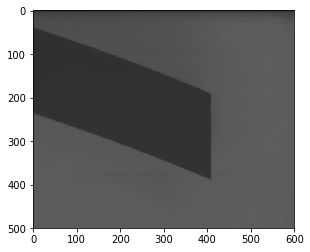

In [125]:
#input_img=cv.imread('342165_20161020-205235_L.tif')
input_img=cv.imread('342165_20161020-205235_R.tif')
pre_img= input_img[0:500, 0:600]

plt.figure(1)
plt.imshow(pre_img)

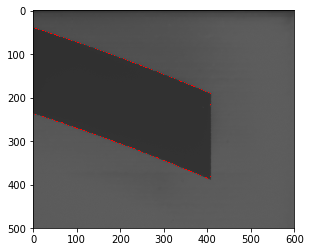

In [126]:
gray = cv.cvtColor(pre_img,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
plt.imshow(gray)

# noise removal
kernel = np.ones((4,4),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 3)
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=5)
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv.watershed(pre_img,markers)
pre_img[markers == -1] = [255,0,0]

plt.imshow(pre_img)

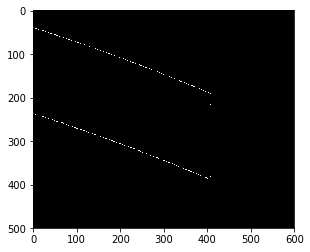

In [127]:
plt.imshow(markers == -1, cmap = 'gray')

In [128]:
markers = markers[1:-2, 1:-2]

x = list(range(markers.shape[1]))
y = list(range(markers.shape[0]))

X, Y = np.meshgrid(x, y)

x_border = X[markers == -1]
y_border = Y[markers == -1]

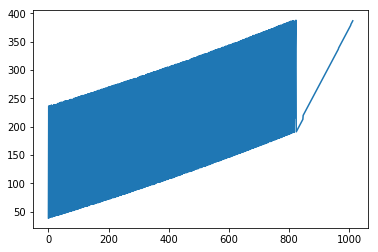

In [129]:
y_border = [x for _,x in sorted(zip(x_border,y_border))]
x_border = sorted(x_border)

plt.plot(y_border)

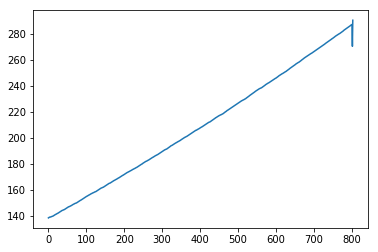

In [149]:
border = markers == -1

window = 10
mov_mean = []
for ii in range(len(y_border) - window):    
    if len(mov_mean) > 2:
        grad = np.gradient(mov_mean)
        if grad[-1] > 5:
            break
    mov_mean.append(np.mean(y_border[ii:(ii+window)]))
    
plt.plot(mov_mean)

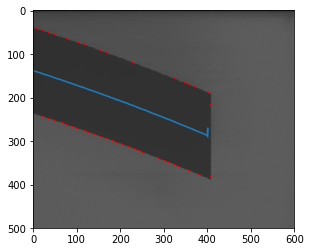

In [150]:
x_border = np.array(x_border[0:len(mov_mean)])
y_border = np.array(y_border[0:len(mov_mean)])
mov_mean = np.array(mov_mean)

plt.plot(x_border, mov_mean)
plt.imshow(pre_img)

0.3718905472636816

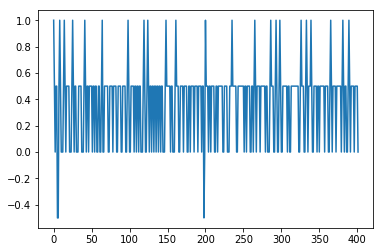

In [151]:
plt.plot(x_border[y_border > mov_mean], np.gradient(y_border[y_border > mov_mean]))

np.mean(np.gradient(y_border[y_border > mov_mean]))

0.3681592039800995

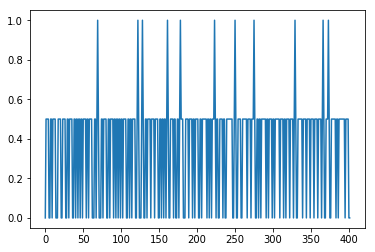

In [152]:
plt.plot(x_border[y_border < mov_mean], np.gradient(y_border[y_border < mov_mean]))
np.mean(np.gradient(y_border[y_border < mov_mean]))

In [153]:
x_up = x_border[y_border > mov_mean]
y_up = y_border[y_border > mov_mean]

x_low = x_border[y_border < mov_mean]
y_low = y_border[y_border < mov_mean]

p_up = np.polyfit(x_up, y_up, 2)
p_low = np.polyfit(x_low, y_low, 2)

print(p_low)
print(p_up)

[1.23542660e-04 3.20408839e-01 3.91104303e+01]
[1.20900916e-04 3.23528137e-01 2.35925293e+02]


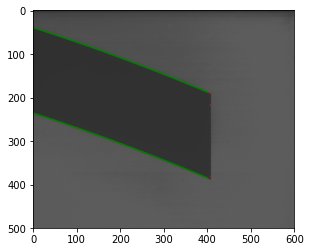

In [154]:
fit_up = np.polyval(p_up, x_up)
fit_low = np.polyval(p_low, x_low)

plt.plot(fit_up, 'g')
plt.plot(fit_low, 'g')
plt.imshow(pre_img)